In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal.windows import tukey, nuttall
from scipy.signal import stft, istft
from sklearn.decomposition import NMF
from IPython.display import Audio

In [4]:
def hamming_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.53836 - 0.46164*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])


def hann_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.5 - 0.5*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])


def wiener_filter(V, WiHi, W, H, alpha=1):
    # El filtro de Wiener permite generar una máscara que obtenga información
    # del espectrograma original a partir de la proporción obtenida mediante la
    # multiplicación de las matrices W y H (estimación de la señal original)
    
    # Obteniendo la máscara
    mask = np.divide(WiHi ** alpha, np.matmul(W, H) + 1e-15)
    
    # Aplicando la máscara al espectrograma original, se obtiene el resultado
    # final del proceso de separación de fuentes
    return mask * V


def raised_cosine_modified(N, beta):
    '''Creación de una ventana tipo pulso coseno elevado.
    
    Parameters
    ----------
    N : int
        Cantidad de puntos de la ventana.
    beta : float
        Parámetro de la función coseno elevado para la apertura de la ventana.
        
    Returns
    -------
    rc_out : ndarray
        Ventana pulso coseno elevado de N puntos con el valor de beta ingresado
    '''
    # Definición de la frecuencia f
    f = np.linspace(-1/2, 1/2, N)
    
    # Control de parámetro para beta
    if beta <= 0:
        beta = 0
    elif beta >= 1:
        beta = 1
    
    # Definición del vector de salida
    rc_out = np.array([])
    
    # Para punto f
    for i in f:
        if abs(i) <= (1 - beta)/2:
            rc_out = np.concatenate((rc_out, [1]))
        elif (1 - beta)/2 < abs(i) <= (1 + beta)/2:
            to_append =  np.cos(np.pi / beta * (abs(i) - (1 - beta)/2))
            rc_out = np.concatenate((rc_out, [to_append]))
        else:
            rc_out = np.concatenate((rc_out, [0]))
            
    return rc_out


def raised_cosine_fading(N, beta, side='right'):
    ''' Creacion de una ventana de desvanecimiento basada en coseno elevado.
    
    Parameters
    ----------
    N : int
        Cantidad de puntos de la ventana.
    beta : float
        Parámetro de la función coseno elevado para la apertura de la ventana.
    side : {'left', 'right'}, optional
        Dirección en la cual se puede usará la ventana. Se recomienda 'right' para
        el final de la señal y 'left' para el comienzo. Por defecto es 'right'.
    
    Returns
    -------
    vanish_window : ndarray
        Ventana de desvanecimiento de N puntos.
    '''    
    # Definición de la frecuencia f
    f = np.linspace(-1, 1, 2*N)
    
    # Control de parámetro para beta
    if beta <= 0:
        beta = 0
    elif beta >= 1:
        beta = 1
    
    # Definición del vector de salida
    rc_out = np.array([])
    
    # Para punto f
    for i in f:
        if abs(i) <= (1 - beta)/2:
            rc_out = np.concatenate((rc_out, [1]))
        elif (1 - beta)/2 < abs(i) <= (1 + beta)/2:
            to_append =  1/2 * (1 + np.cos(np.pi / beta * (abs(i) - (1 - beta)/2)))
            rc_out = np.concatenate((rc_out, [to_append]))
        else:
            rc_out = np.concatenate((rc_out, [0]))
    
    # Selección del lado
    if side == 'right':
        vanish_window = rc_out[N:]
    elif side == 'left':
        vanish_window = 1 - rc_out[N:]
    
    return vanish_window

In [173]:
def get_spectrogram(signal_in, samplerate, N=512, padding=0, noverlap=0, 
                    window='tukey', whole=False):
    # Corroboración de criterios: noverlap <= N - 1
    if N <= noverlap:
        raise Exception('noverlap debe ser menor que N.')
    elif noverlap < 0:
        raise Excepetion('noverlap no puede ser negativo')
    else:
        noverlap = int(noverlap)
    
    # Lista donde se almacenará los valores del espectrograma
    to_fft = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Definición del paso de avance
    step = N - noverlap
    
    # Si el norverlap es 0, se hacen ventanas 2 muestras más grandes 
    # para no considerar los bordes izquierdo y derecho (que son 0)
    if noverlap == 0:
        N_window = N + 2
    else:
        N_window = N
    
    # Seleccionar ventana.
    if window == 'tukey':
        wind_mask = tukey(N_window)
    elif window == 'hamming':
        wind_mask = hamming_window(N_window)
    elif window == 'hann':
        wind_mask = hann_window(N_window)
    elif window == 'nuttall':
        wind_mask = nuttall(N_window)
    elif window is None:
        wind_mask = np.array([1] * N_window)
    
    # Y se recorta en caso de noverlap cero
    wind_mask = wind_mask[1:-1] if noverlap == 0 else wind_mask
    
    # Definición de bordes de signal_in
    signal_in = np.concatenate((np.zeros(N//2), signal_in, np.zeros(N//2)))
    
    # Iteración sobre el audio
    while signal_in.size != 0:
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= N:
            # Se obtienen las N muestras de interés
            signal_frame = signal_in[:N]
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[step:]
            
        # En la última iteración se añaden ceros para lograr el largo N
        else:
            # Definición del último frame
            last_frame = signal_in[:]
            print(N- len(last_frame))
            
            # Se rellena con ceros hasta lograr el largo            
            signal_frame = np.append(last_frame, [0] * (N - len(last_frame)))
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[:0]
    
        # Agregando a los vectores del espectro
        to_fft.append(signal_frame)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Ventaneando
    signal_wind = np.array(to_fft) * wind_mask

    # Aplicando padding
    zeros = np.zeros((signal_wind.shape[0], padding), dtype=signal_wind.dtype)    
    signal_padded = np.concatenate((signal_wind, zeros), axis=1)

    # Aplicando transformada de fourier
    spect = np.fft.fft(signal_padded)
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a
    # que está reflejado hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N+padding)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex128)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, (N+padding)//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex128)[:, :(N+padding)//2 + 1]

    # Escalando
    spect *= np.sqrt(1 / (N * np.sum(wind_mask ** 2)))
    
    # Se retornan los valores que permiten construir el espectrograma 
    # correspondiente
    return times, freqs, spect.T


def get_inverse_spectrogram(X, N=None, noverlap=0, window='tukey', whole=False):
    # Preguntar si es que la señal está en el rango 0-samplerate. En caso de 
    # que no sea así, se debe concatenar el conjugado de la señal para 
    # recuperar el espectro. Esto se hace así debido a la propiedad de las 
    # señales reales que dice que la FT de una señal real entrega una señal 
    # hermitiana (parte real par, parte imaginaria impar). Luego, como solo 
    # tenemos la mitad de la señal, la otra parte correspondiente a la señal 
    # debiera ser la misma pero conjugada, para que al transformar esta señal 
    # hermitiana mediante la IFT, se recupere una señal real (correspondiente a 
    # la señal de audio).
    
    if not whole:
        # Se refleja lo existente utilizando el conjugado
        X = np.concatenate((X, np.flip(np.conj(X[1:-1, :]), axis=0)))
            
    # Obtener la dimensión de la matriz
    rows, cols = X.shape
        
    # Corroboración de criterios: noverlap <= N - 1
    if rows <= noverlap:
        raise Exception('noverlap debe ser menor que la dimensión fila.')
    else:
        noverlap = int(noverlap)
    
    # Definición de N dependiendo de la naturaleza de la situación
    if N is None or N > rows:
        N = rows
    
    # Si el norverlap es 0, se hacen ventanas 2 muestras más grandes 
    # para no considerar los bordes izquierdo y derecho (que son 0)
    if noverlap == 0:
        N_window = N + 2
    else:
        N_window = N
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(N_window)
    elif window == 'hamming':
        wind_mask = hamming_window(N_window)
    elif window == 'hann':
        wind_mask = hann_window(N_window)
    elif window == 'nuttall':
        wind_mask = nuttall(N_window)
    elif window is None:
        wind_mask = np.array([1] * N_window)
        
    # Y se recorta en caso de noverlap cero
    wind_mask = wind_mask[1:-1] if noverlap == 0 else wind_mask
    
    # Destransformando y re escalando se obtiene
    ifft_scaled = np.fft.ifft(X, axis=0) * np.sqrt(N * np.sum(wind_mask ** 2))
    
    # Si N es menor que la dimensión de filas, significa que está padeada
    ifft_scaled = ifft_scaled[:N,:] 
    
    # A partir del overlap, el tamaño de cada ventana de la fft (dimensión fila)
    # y la cantidad de frames a las que se les aplicó la transformación 
    # (dimensión columna), se define la cantidad de muestras que representa la
    # señal original
    step = N - noverlap                     # Tamaño del paso
    total_samples = step * (cols - 1) + N   # Tamaño total del arreglo
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_spect = np.zeros(total_samples, dtype=np.complex128)
    # Definición de una lista de suma de ventanas cuadráticas en el tiempo
    sum_wind = np.zeros(total_samples, dtype=np.complex128)
    
    # Transformando columna a columna (nótese la división en tiempo por una 
    # ventana definida)
    for i in range(cols):
        beg = i * step
        # Se multiplica por el kernel para la reconstrucción a partir de la
        # ventana aplicada inicialmente. Fuente:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html        
        # Agregando al arreglo
        inv_spect[beg:beg+N] += ifft_scaled[:, i]
        
        # Se suma la ventana (que sirve como ponderador)
        sum_wind[beg:beg+N] += wind_mask
    
    # Se corta el padding agregado
    inv_spect = inv_spect[N//2:-N//2]
    sum_wind = sum_wind[N//2:-N//2]
    
    # Finalmente se aplica la normalización por la cantidad de veces que se
    # suma cada muestra en el proceso anterior producto del traslape,
    # utilizando las ventanas correspondientes
    return np.real(np.divide(inv_spect, np.where(sum_wind > 1e-10, sum_wind, 1)))
    
    
def nmf_decomposition(signal_in, samplerate, n_components=2, N=2048, overlap=0.75, 
                      padding=0, window='hamming', whole=False, alpha_wiener=1,  
                      wiener_filt=True, init='random', solver='cd', beta=2,
                      tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                      random_state=None, W_0=None, H_0=None):
    '''Función que permite separar una señal utilizando la descomposición NMF,
    la cual usa como entrada al sistema el espectrograma de la señal de audio.
    Además utiliza todos los parámetros relevantes para este estudio del comando
    NMF programado en la librería sklearn [2].
        
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    samplerate : int
        Tasa de muestreo de la señal.
    n_components : int, optional
        Cantidad de componentes a separar la señal. Por defecto es 2.
    N : int, optional
        Cantidad de puntos utilizados en cada ventana de la STFT. Por defecto es 2048.
    overlap : float, optional
        Nivel de traslape que existe entre una ventana y la siguiente al calcular la 
        STFT. Por defecto es 0.75 (75%).
    padding : int, optional
        Cantidad de ceros añadidos al final para aplicar zero padding. Por defecto es 0.
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}, optional
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
        En caso de elegir None, se asume la ventana rectangular. Por defecto es 'hamming'.
    whole : bool, optional
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mtiad. Por defecto es False.
    alpha_wiener : int, optional
        Exponente alpha del filtro de Wiener. Por defecto es 1.
    wiener_filt : bool, optional
        Indica si se aplica el filtro de wiener una vez separado ambas componentes.
        Por defecto es True.
    init : {'random', 'custom'}, optional
        Opción de puntos de inicio de la descomposición. 'random' inicia con puntos al
        azar, y 'custom' permite ingresar matrices en "W_0" y "H_0" como puntos iniciales.
        Por defecto es 'random'.
    solver : {'cd', 'mu'}, optional
        Solver numérico a usar. Por defecto es 'cd'.
    beta : {'frobenius', 'kullback-leibler', 'itakura-saito'}, float or string, optional
        Definición de la beta divergencia. Por defecto es 'frobenius' (o 2).
    tol: float, optional
        Tolerancia de la condición de parada. Por defecto es 1e-4.
    max_iter: int, optional
        Cantidad máxima de iteraciones. Por defecto es 200.
    alpha_nmf: float, optional
        Constante que multiplica los términos de regulación en la resolución del problema.
        Por defecto es 0.
    l1_ratio : float, optional
        Parámetro de regulación usado en 'cd'. Por defecto es 0.
    random_state : int, RandomState instance or None, optional
        En caso de ser un "int", actúa como semilla. Si es una instancia "RandomState",
        la variable es el generador de números aleatorios. Si es "None", el número aleatorio
        es un número aleatorio generado por np.random. Por defecto es None.
    W_0 : None or ndarray, optional
        Punto de inicio para W. Por defecto es None.
    H_0 : None or ndarray, optional
        Punto de inicio para H. Por defecto es None.
    
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
    X : ndarray
        Magnitud del spectrograma de la señal de entrada (entrada NMF).
    W : ndarray
        Matriz W (plantillas espectrales) de la descomposición NMF.
    H : ndarray
        Matriz H (plantillas temporales) de la descomposición NMF.
    
    References
    ----------
    [1] Tutorial: https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf
    [2] https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
    '''
    # Propiedad del overlap
    overlap = 0.99 if overlap >= 0.99 else overlap
    
    # Definición de una lista que almacene las componentes
    components = []
    # Listas de valores de interés
    Y_list = []
    
    # Obteniendo el espectrograma
    _, _, S = get_spectrogram(signal_in, samplerate, N=N, padding=padding, 
                              overlap=overlap, window=window, whole=whole)
    
    # Definiendo la magnitud del espectrograma (elemento a estimar)
    X = np.abs(S)
    
    # Definiendo el modelo de NMF
    model = NMF(n_components=n_components, init=init, solver=solver,
                beta_loss=beta, tol=tol, max_iter=max_iter, 
                random_state=random_state, alpha=alpha_nmf, l1_ratio=l1_ratio)
    
    # Ajustando W
    if init == 'random':
        W = model.fit_transform(X)
    elif init == 'custom':
        W = model.fit_transform(X, W=W_0, H=H_0)
    else:
        raise Exception('Opción de inicio no disponible. Por favor intente nuevamente.')
    
    # Ajustando H
    H = model.components_
    
    # Se define la función de transformación para Yi
    if wiener_filt:
        # Se aplica filtro de Wiener
        filt = lambda source_i: wiener_filter(X, source_i, W, H, alpha=alpha_wiener)
    else:
        # Solo se entrega la multiplicación W_i * H_i
        filt = lambda source_i: source_i
    
    # Obteniendo las fuentes
    for i in range(n_components):
        source_i = np.outer(W[:,i], H[i])
        
        # Aplicando el filtro
        Yi = filt(source_i) * np.exp(1j * np.angle(S))
        
        # Y posteriormente la transformada inversa
        yi = get_inverse_spectrogram(Yi, overlap=overlap, window=window, 
                                     whole=whole)
                
        # Agregando a la lista de componentes
        components.append(np.real(yi))
        Y_list.append(Yi)
        
    return components, Y_list, X, W, H

# Experimento 1: Comparación resultados espectrograma / Señal original

In [11]:
filename = 'HR 122_2b2_Al_mc_LittC2SE Seed[2732]_S1[59]_S2[60]'
audio, samplerate = sf.read(f'{filename}.wav')
Audio(audio, rate=samplerate)

In [187]:
# Parameters
N = 512
padding = 0
noverlap = N//2
window = 'hann'
whole = False

t, f, S = get_spectrogram(audio, samplerate, N=N, padding=padding, noverlap=noverlap, 
                          window=window, whole=whole)

print(S.shape)
print()
#_,_, S_half = get_spectrogram(audio, samplerate, N=N, padding=padding, overlap=overlap, 
#                          window=window, whole=False)

signal_recomposed = get_inverse_spectrogram(S, N=N, noverlap=noverlap, window=window, whole=whole)


print(len(audio))
print(len(signal_recomposed))
print(len(signal_recomposed) - len(audio))

93
(257, 2498)

639139
639232
93


<IPython.core.display.Javascript object>


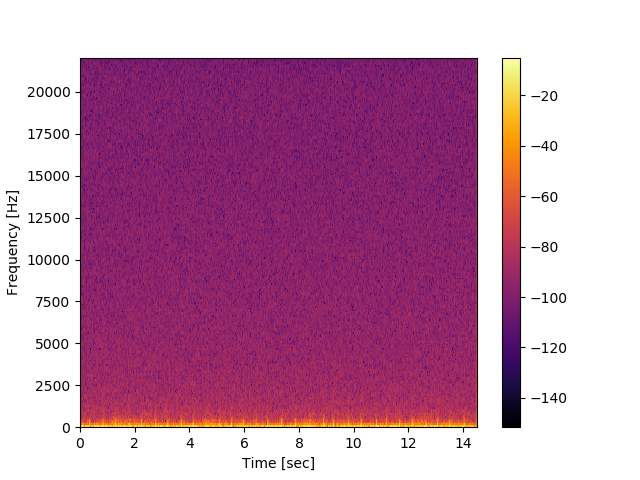

In [188]:
%matplotlib notebook

X = abs(S)

plt.pcolormesh(t, f, 20*np.log10(X), cmap='inferno')
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

<IPython.core.display.Javascript object>


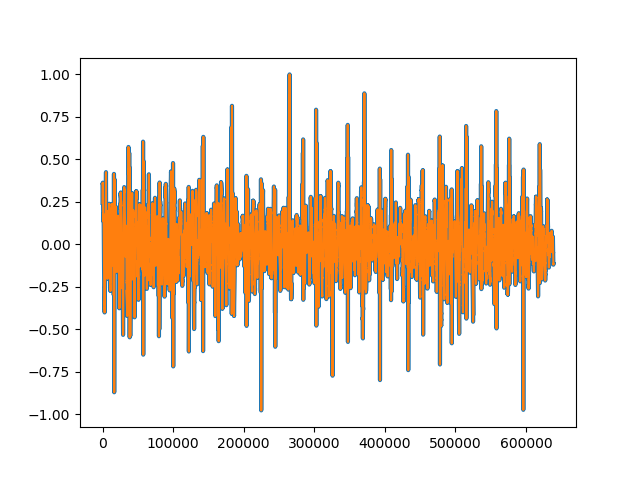

In [189]:
%matplotlib notebook
plt.plot(signal_recomposed[:len(audio)], linewidth=3)
plt.plot(audio)
plt.show()

<IPython.core.display.Javascript object>


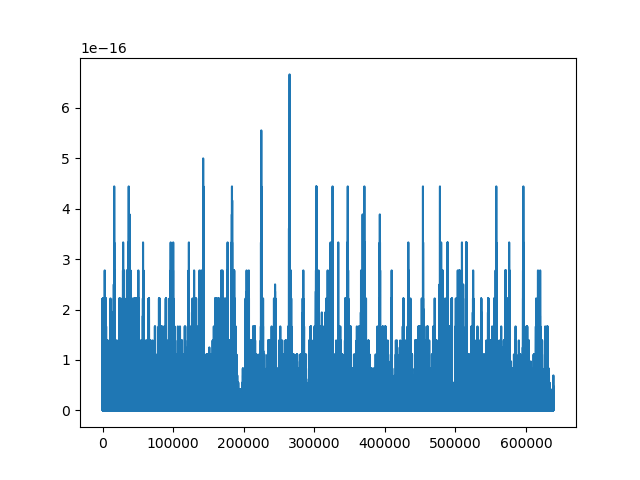

In [190]:
%matplotlib notebook
plt.plot(abs(audio-signal_recomposed[:len(audio)]))
plt.show()

(257, 2498)
639139
639232
93


<IPython.core.display.Javascript object>


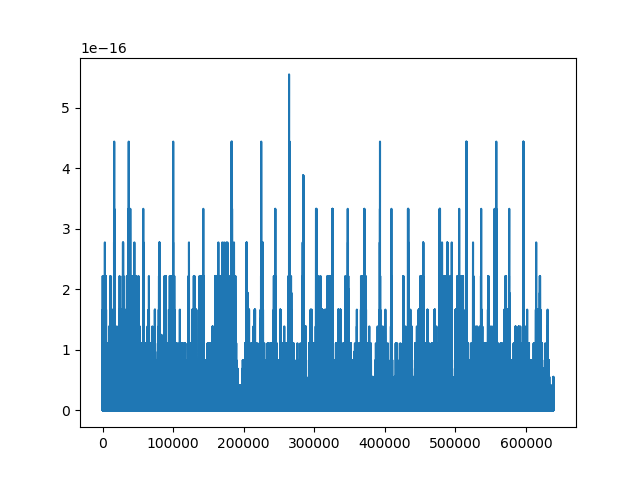

In [191]:
f_stft, t_stft,s_stft = stft(audio, fs=samplerate,  window=window, nperseg=N, 
                             boundary='zeros', noverlap=noverlap, return_onesided=not whole)

print(s_stft.shape)
_,signal_rec2 = istft(s_stft, fs=samplerate, nperseg=N, noverlap=noverlap, input_onesided=not whole)

print(len(audio))
print(len(signal_rec2))
print(len(signal_rec2) - len(audio))

%matplotlib notebook
plt.plot(abs(audio-signal_rec2[:len(audio)]))
plt.show()

(257,)


<IPython.core.display.Javascript object>


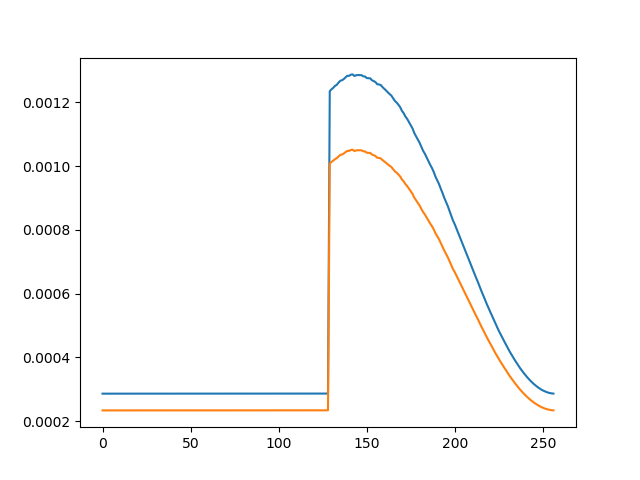

In [192]:
test = np.fft.ifft(s_stft[:,0])
test2 = np.fft.ifft(S[:,0])
print(test.shape)
%matplotlib notebook
plt.plot(test)
plt.plot(test2)
plt.show()

<IPython.core.display.Javascript object>


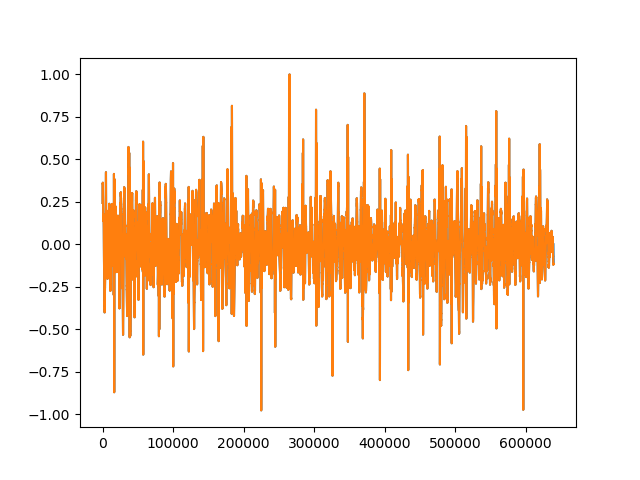

In [193]:
%matplotlib notebook
plt.plot(signal_rec2)
plt.plot(audio)
plt.show()

<IPython.core.display.Javascript object>


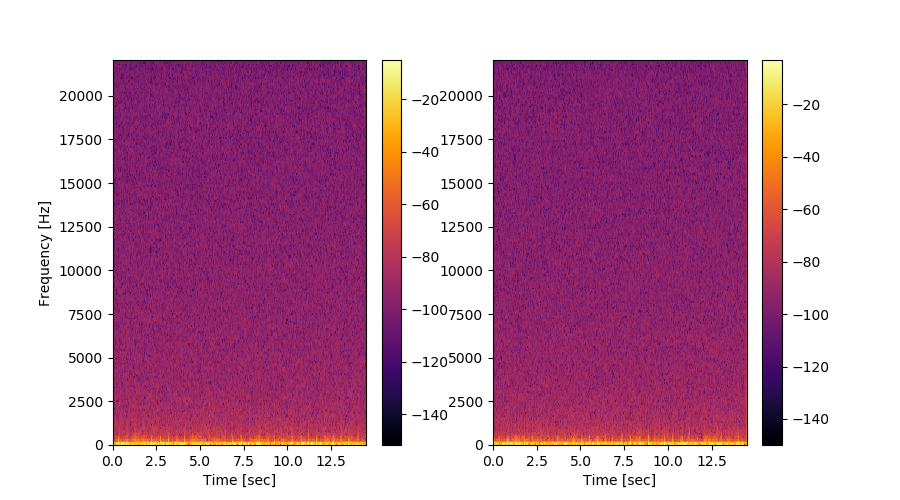

In [194]:
%matplotlib notebook

X1 = abs(S)
X2 = abs(s_stft)

plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.pcolormesh(t, f, 20*np.log10(X1), cmap='inferno')
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(1,2,2)
plt.pcolormesh(t_stft, f_stft, 20*np.log10(X2), cmap='inferno')
plt.colorbar()
plt.xlabel('Time [sec]')

plt.show()

<IPython.core.display.Javascript object>


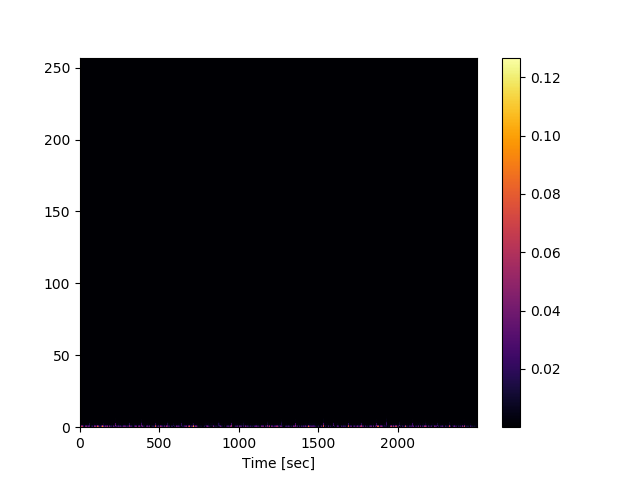

In [195]:
%matplotlib notebook
plt.pcolormesh(abs(X1 - X2[:,:X1.shape[1]]), cmap='inferno')
plt.colorbar()
plt.xlabel('Time [sec]')

plt.show()